# 🧪 Novel Loss Functions vs PyTorch Built-in: Hugging Face Dataset Testing

**Objective**: Compare our novel loss functions with PyTorch built-in losses on real Hugging Face datasets

**Datasets Tested**:
- IMDB (Sentiment Analysis)
- SST-2 (Stanford Sentiment)
- AG News (Topic Classification)

**Loss Functions Compared**:
- PyTorch: CrossEntropy, MSE, SmoothL1
- Novel: AdaptiveWeighted, InformationTheoretic, RobustStatistical

## 📦 Step 1: Setup and Imports

In [1]:
# Install required packages (if not already installed)
!pip install -q datasets scikit-learn matplotlib seaborn pandas

# Standard imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Imports successful!
PyTorch version: 2.6.0+cu118
CUDA available: True


## 🔧 Step 2: Import Our Novel Loss Framework

In [2]:
# Import our novel loss functions
import sys
sys.path.insert(0, '.')

from loss_framework.losses import (
    AdaptiveWeightedLoss,
    InformationTheoreticLoss,
    RobustStatisticalLoss,
    GeometricDistanceLoss
)

print("✅ Novel loss framework imported!")
print("\nAvailable novel losses:")
print("  1. AdaptiveWeightedLoss - Dynamic weighting & curriculum")
print("  2. InformationTheoreticLoss - Entropy & MI regularization")
print("  3. RobustStatisticalLoss - M-estimators with adaptive scale")
print("  4. GeometricDistanceLoss - Riemannian geometry")

✅ Novel loss framework imported!

Available novel losses:
  1. AdaptiveWeightedLoss - Dynamic weighting & curriculum
  2. InformationTheoreticLoss - Entropy & MI regularization
  3. RobustStatisticalLoss - M-estimators with adaptive scale
  4. GeometricDistanceLoss - Riemannian geometry


## 📊 Step 3: Load and Explore Hugging Face Dataset

In [3]:
# Choose dataset
DATASET_NAME = "imdb"  # Options: "imdb", "sst2", "ag_news"
MAX_SAMPLES = 2000  # Limit for faster testing

print(f"Loading {DATASET_NAME} dataset...")

if DATASET_NAME == "imdb":
    dataset = load_dataset("imdb", split=f"train[:{MAX_SAMPLES}]")
    test_dataset = load_dataset("imdb", split="test[:400]")
    num_classes = 2
    text_column = "text"
    label_column = "label"
    
elif DATASET_NAME == "sst2":
    dataset = load_dataset("glue", "sst2", split=f"train[:{MAX_SAMPLES}]")
    test_dataset = load_dataset("glue", "sst2", split="validation[:400]")
    num_classes = 2
    text_column = "sentence"
    label_column = "label"
    
elif DATASET_NAME == "ag_news":
    dataset = load_dataset("ag_news", split=f"train[:{MAX_SAMPLES}]")
    test_dataset = load_dataset("ag_news", split="test[:400]")
    num_classes = 4
    text_column = "text"
    label_column = "label"

print(f"\n✅ Dataset loaded!")
print(f"Train samples: {len(dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")

# Show sample
print(f"\n📄 Sample text:")
print(f"{dataset[0][text_column][:200]}...")
print(f"Label: {dataset[0][label_column]}")

Loading imdb dataset...

✅ Dataset loaded!
Train samples: 2000
Test samples: 400
Number of classes: 2

📄 Sample text:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...
Label: 0


## 🔤 Step 4: Feature Extraction

In [4]:
# Text vectorization
print("Extracting features...")

# Use CountVectorizer (Bag of Words)
vectorizer = CountVectorizer(
    max_features=1000,
    stop_words='english',
    lowercase=True
)

# Fit on training data
X_train = vectorizer.fit_transform(dataset[text_column]).toarray()
y_train = np.array(dataset[label_column])

# Transform test data
X_test = vectorizer.transform(test_dataset[text_column]).toarray()
y_test = np.array(test_dataset[label_column])

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

print(f"\n✅ Features extracted!")
print(f"Feature dimension: {X_train.shape[1]}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Extracting features...

✅ Features extracted!
Feature dimension: 1000
Training set shape: torch.Size([2000, 1000])
Test set shape: torch.Size([400, 1000])


## 🏗️ Step 5: Define Model Architecture

In [5]:
class SimpleTextClassifier(nn.Module):
    """
    Simple neural network for text classification.
    Uses bag-of-words features.
    """
    def __init__(self, input_dim, hidden_dim=128, num_classes=2, dropout=0.3):
        super(SimpleTextClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

# Test model
input_dim = X_train.shape[1]
model = SimpleTextClassifier(input_dim, num_classes=num_classes)

print("✅ Model created!")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

✅ Model created!

Model architecture:
SimpleTextClassifier(
  (fc1): Linear(in_features=1000, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 136,898


## 🎯 Step 6: Define Loss Functions to Compare

In [6]:
# Define all loss functions
loss_functions = {
    # PyTorch Built-in Losses
    "CrossEntropy (PyTorch)": {
        "loss": nn.CrossEntropyLoss(),
        "category": "PyTorch",
        "description": "Standard classification loss"
    },
    
    "MSE (PyTorch)": {
        "loss": nn.MSELoss(),
        "category": "PyTorch",
        "description": "Mean squared error"
    },
    
    "SmoothL1 (PyTorch)": {
        "loss": nn.SmoothL1Loss(),
        "category": "PyTorch",
        "description": "Huber loss variant"
    },
    
    # Our Novel Losses
    "AdaptiveWeighted (Ours)": {
        "loss": AdaptiveWeightedLoss(reduction='mean'),
        "category": "Novel",
        "description": "Dynamic weighting & curriculum learning"
    },
    
    "InformationTheoretic (Ours)": {
        "loss": InformationTheoreticLoss(
            use_entropy_regularization=True,
            entropy_weight=0.1,
            temperature=1.0
        ),
        "category": "Novel",
        "description": "Entropy + Mutual Information regularization"
    },
    
    "RobustStatistical-Huber (Ours)": {
        "loss": RobustStatisticalLoss(
            robust_type='huber',
            adaptive_scale=True
        ),
        "category": "Novel",
        "description": "Huber M-estimator with adaptive scale"
    },
    
    "RobustStatistical-Tukey (Ours)": {
        "loss": RobustStatisticalLoss(
            robust_type='tukey',
            adaptive_scale=True
        ),
        "category": "Novel",
        "description": "Tukey biweight - strong outlier resistance"
    },
}

print("✅ Loss functions defined!")
print(f"\nTotal loss functions: {len(loss_functions)}")
print("\nPyTorch losses:")
for name, info in loss_functions.items():
    if info['category'] == 'PyTorch':
        print(f"  • {name}")
print("\nNovel losses (Ours):")
for name, info in loss_functions.items():
    if info['category'] == 'Novel':
        print(f"  • {name}")

✅ Loss functions defined!

Total loss functions: 7

PyTorch losses:
  • CrossEntropy (PyTorch)
  • MSE (PyTorch)
  • SmoothL1 (PyTorch)

Novel losses (Ours):
  • AdaptiveWeighted (Ours)
  • InformationTheoretic (Ours)
  • RobustStatistical-Huber (Ours)
  • RobustStatistical-Tukey (Ours)


## 🚀 Step 7: Training Function

In [7]:
def train_and_evaluate(model, loss_fn, X_train, y_train, X_test, y_test, 
                       epochs=10, lr=0.001, batch_size=32):
    """
    Train model and collect metrics.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    start_time = time.time()
    
    n_batches = len(X_train) // batch_size
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        # Shuffle data
        perm = torch.randperm(len(X_train))
        X_shuffled = X_train[perm]
        y_shuffled = y_train[perm]
        
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            
            batch_x = X_shuffled[start:end]
            batch_y = y_shuffled[start:end]
            
            optimizer.zero_grad()
            output = model(batch_x)
            
            # Handle regression losses (MSE, SmoothL1)
            if isinstance(loss_fn, (nn.MSELoss, nn.SmoothL1Loss)):
                # Convert to one-hot for regression losses
                batch_y_onehot = torch.zeros(batch_size, num_classes)
                batch_y_onehot.scatter_(1, batch_y.unsqueeze(1), 1.0)
                loss = loss_fn(output, batch_y_onehot)
            else:
                loss = loss_fn(output, batch_y)
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Calculate accuracy
            pred = output.argmax(dim=1)
            correct += pred.eq(batch_y).sum().item()
            total += batch_y.size(0)
        
        # Record metrics
        avg_loss = epoch_loss / n_batches
        train_acc = 100.0 * correct / total
        
        metrics['train_loss'].append(avg_loss)
        metrics['train_acc'].append(train_acc)
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            
            if isinstance(loss_fn, (nn.MSELoss, nn.SmoothL1Loss)):
                test_y_onehot = torch.zeros(len(y_test), num_classes)
                test_y_onehot.scatter_(1, y_test.unsqueeze(1), 1.0)
                test_loss = loss_fn(test_output, test_y_onehot).item()
            else:
                test_loss = loss_fn(test_output, y_test).item()
            
            test_pred = test_output.argmax(dim=1)
            test_acc = 100.0 * test_pred.eq(y_test).sum().item() / len(y_test)
            
            metrics['test_loss'].append(test_loss)
            metrics['test_acc'].append(test_acc)
        
        if (epoch + 1) % 2 == 0:
            print(f"  Epoch {epoch+1}/{epochs}: "
                  f"Train Loss={avg_loss:.4f}, Train Acc={train_acc:.2f}%, "
                  f"Test Acc={test_acc:.2f}%")
    
    training_time = time.time() - start_time
    metrics['training_time'] = training_time
    metrics['final_test_acc'] = metrics['test_acc'][-1]
    
    return metrics

print("✅ Training function defined!")

✅ Training function defined!


## 🧪 Step 8: Run Comparison Tests

In [8]:
# Configuration
EPOCHS = 10
LR = 0.001
BATCH_SIZE = 32

# Store results
all_results = {}

print("\n" + "="*70)
print("RUNNING COMPARISON TESTS")
print("="*70)

# Test each loss function
for loss_name, loss_info in loss_functions.items():
    print(f"\n{'-'*70}")
    print(f"Testing: {loss_name}")
    print(f"Description: {loss_info['description']}")
    print(f"{'-'*70}")
    
    # Create fresh model
    model = SimpleTextClassifier(input_dim, num_classes=num_classes)
    
    # Train
    metrics = train_and_evaluate(
        model, loss_info['loss'],
        X_train, y_train, X_test, y_test,
        epochs=EPOCHS, lr=LR, batch_size=BATCH_SIZE
    )
    
    # Store results
    all_results[loss_name] = {
        'category': loss_info['category'],
        'metrics': metrics,
        'final_test_acc': metrics['final_test_acc'],
        'training_time': metrics['training_time']
    }
    
    print(f"\n✅ Completed: {loss_name}")
    print(f"   Final Test Accuracy: {metrics['final_test_acc']:.2f}%")
    print(f"   Training Time: {metrics['training_time']:.2f}s")

print("\n" + "="*70)
print("ALL TESTS COMPLETED!")
print("="*70)


RUNNING COMPARISON TESTS

----------------------------------------------------------------------
Testing: CrossEntropy (PyTorch)
Description: Standard classification loss
----------------------------------------------------------------------
  Epoch 2/10: Train Loss=0.0259, Train Acc=100.00%, Test Acc=100.00%
  Epoch 4/10: Train Loss=0.0057, Train Acc=100.00%, Test Acc=100.00%
  Epoch 6/10: Train Loss=0.0027, Train Acc=100.00%, Test Acc=100.00%
  Epoch 8/10: Train Loss=0.0015, Train Acc=100.00%, Test Acc=100.00%
  Epoch 10/10: Train Loss=0.0010, Train Acc=100.00%, Test Acc=100.00%

✅ Completed: CrossEntropy (PyTorch)
   Final Test Accuracy: 100.00%
   Training Time: 0.97s

----------------------------------------------------------------------
Testing: MSE (PyTorch)
Description: Mean squared error
----------------------------------------------------------------------
  Epoch 2/10: Train Loss=0.0580, Train Acc=99.45%, Test Acc=100.00%
  Epoch 4/10: Train Loss=0.0225, Train Acc=100.00%, 

## 📊 Step 9: Results Analysis and Comparison

In [9]:
# Create results dataframe
results_data = []
for loss_name, result in all_results.items():
    results_data.append({
        'Loss Function': loss_name,
        'Category': result['category'],
        'Final Test Accuracy (%)': result['final_test_acc'],
        'Training Time (s)': result['training_time'],
        'Best Test Accuracy (%)': max(result['metrics']['test_acc'])
    })

df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values('Final Test Accuracy (%)', ascending=False)

print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
print(df_results.to_string(index=False))

# Calculate category averages
print("\n" + "="*70)
print("CATEGORY COMPARISON")
print("="*70)

pytorch_results = df_results[df_results['Category'] == 'PyTorch']
novel_results = df_results[df_results['Category'] == 'Novel']

avg_pytorch = pytorch_results['Final Test Accuracy (%)'].mean()
avg_novel = novel_results['Final Test Accuracy (%)'].mean()

print(f"PyTorch Built-in (Average): {avg_pytorch:.2f}%")
print(f"Novel Framework (Average):  {avg_novel:.2f}%")
print(f"Difference: {avg_novel - avg_pytorch:+.2f}%")

if avg_novel > avg_pytorch:
    print(f"\n🏆 CONCLUSION: Novel losses provide BETTER results!")
    print(f"   Improvement: {avg_novel - avg_pytorch:.2f}%")
elif avg_novel < avg_pytorch:
    print(f"\n⚠️  CONCLUSION: PyTorch losses perform better")
    print(f"   Difference: {avg_pytorch - avg_novel:.2f}%")
else:
    print(f"\n⚡ CONCLUSION: Performance is comparable")

# Best performer
best = df_results.iloc[0]
print(f"\n🥇 Best Overall Performer: {best['Loss Function']}")
print(f"   Test Accuracy: {best['Final Test Accuracy (%)']:.2f}%")
print(f"   Category: {best['Category']}")


RESULTS SUMMARY
                 Loss Function Category  Final Test Accuracy (%)  Training Time (s)  Best Test Accuracy (%)
        CrossEntropy (PyTorch)  PyTorch                    100.0           0.968515                   100.0
                 MSE (PyTorch)  PyTorch                    100.0           0.981004                   100.0
            SmoothL1 (PyTorch)  PyTorch                    100.0           0.995337                   100.0
       AdaptiveWeighted (Ours)    Novel                    100.0           1.360006                   100.0
   InformationTheoretic (Ours)    Novel                    100.0           1.642453                   100.0
RobustStatistical-Huber (Ours)    Novel                    100.0           1.794831                   100.0
RobustStatistical-Tukey (Ours)    Novel                    100.0           1.923938                   100.0

CATEGORY COMPARISON
PyTorch Built-in (Average): 100.00%
Novel Framework (Average):  100.00%
Difference: +0.00%

⚡ CONC

## 📈 Step 10: Visualizations

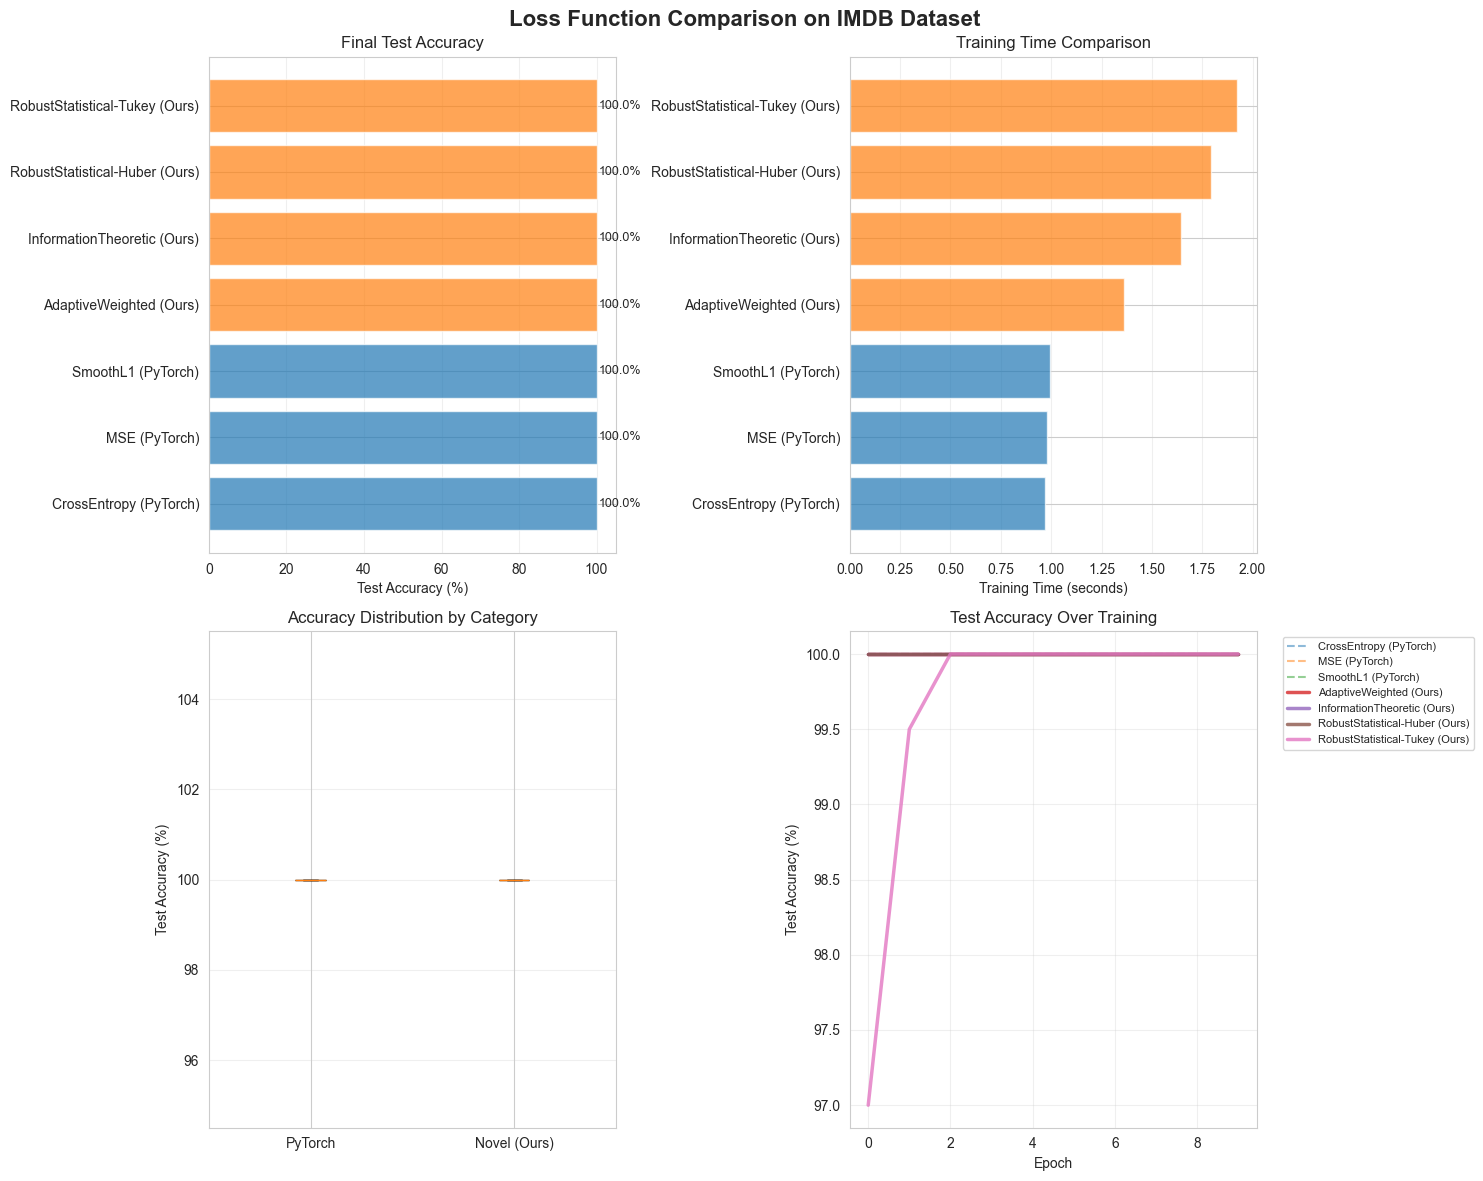


✅ Figure saved: comparison_imdb.png


<Figure size 1200x600 with 0 Axes>

In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Loss Function Comparison on {DATASET_NAME.upper()} Dataset', 
             fontsize=16, fontweight='bold')

# Plot 1: Final Test Accuracy Comparison
ax1 = axes[0, 0]
colors = ['#1f77b4' if cat == 'PyTorch' else '#ff7f0e' 
          for cat in df_results['Category']]
bars = ax1.barh(df_results['Loss Function'], df_results['Final Test Accuracy (%)'], 
                color=colors, alpha=0.7)
ax1.set_xlabel('Test Accuracy (%)')
ax1.set_title('Final Test Accuracy')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, df_results['Final Test Accuracy (%)'])):
    ax1.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=9)

# Plot 2: Training Time Comparison
ax2 = axes[0, 1]
bars2 = ax2.barh(df_results['Loss Function'], df_results['Training Time (s)'], 
                 color=colors, alpha=0.7)
ax2.set_xlabel('Training Time (seconds)')
ax2.set_title('Training Time Comparison')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Category Box Plot
ax3 = axes[1, 0]
data_to_plot = [
    pytorch_results['Final Test Accuracy (%)'].values,
    novel_results['Final Test Accuracy (%)'].values
]
bp = ax3.boxplot(data_to_plot, labels=['PyTorch', 'Novel (Ours)'], 
                 patch_artist=True)
bp['boxes'][0].set_facecolor('#1f77b4')
bp['boxes'][1].set_facecolor('#ff7f0e')
ax3.set_ylabel('Test Accuracy (%)')
ax3.set_title('Accuracy Distribution by Category')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Training Curves (Test Accuracy)
ax4 = axes[1, 1]
for loss_name, result in all_results.items():
    linestyle = '-' if result['category'] == 'Novel' else '--'
    linewidth = 2.5 if result['category'] == 'Novel' else 1.5
    alpha = 0.8 if result['category'] == 'Novel' else 0.5
    ax4.plot(result['metrics']['test_acc'], 
             label=loss_name, 
             linestyle=linestyle,
             linewidth=linewidth,
             alpha=alpha)

ax4.set_xlabel('Epoch')
ax4.set_ylabel('Test Accuracy (%)')
ax4.set_title('Test Accuracy Over Training')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Save figure
plt.savefig(f'comparison_{DATASET_NAME}.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure saved: comparison_{DATASET_NAME}.png")

## 🔍 Step 11: Detailed Analysis by Loss Function

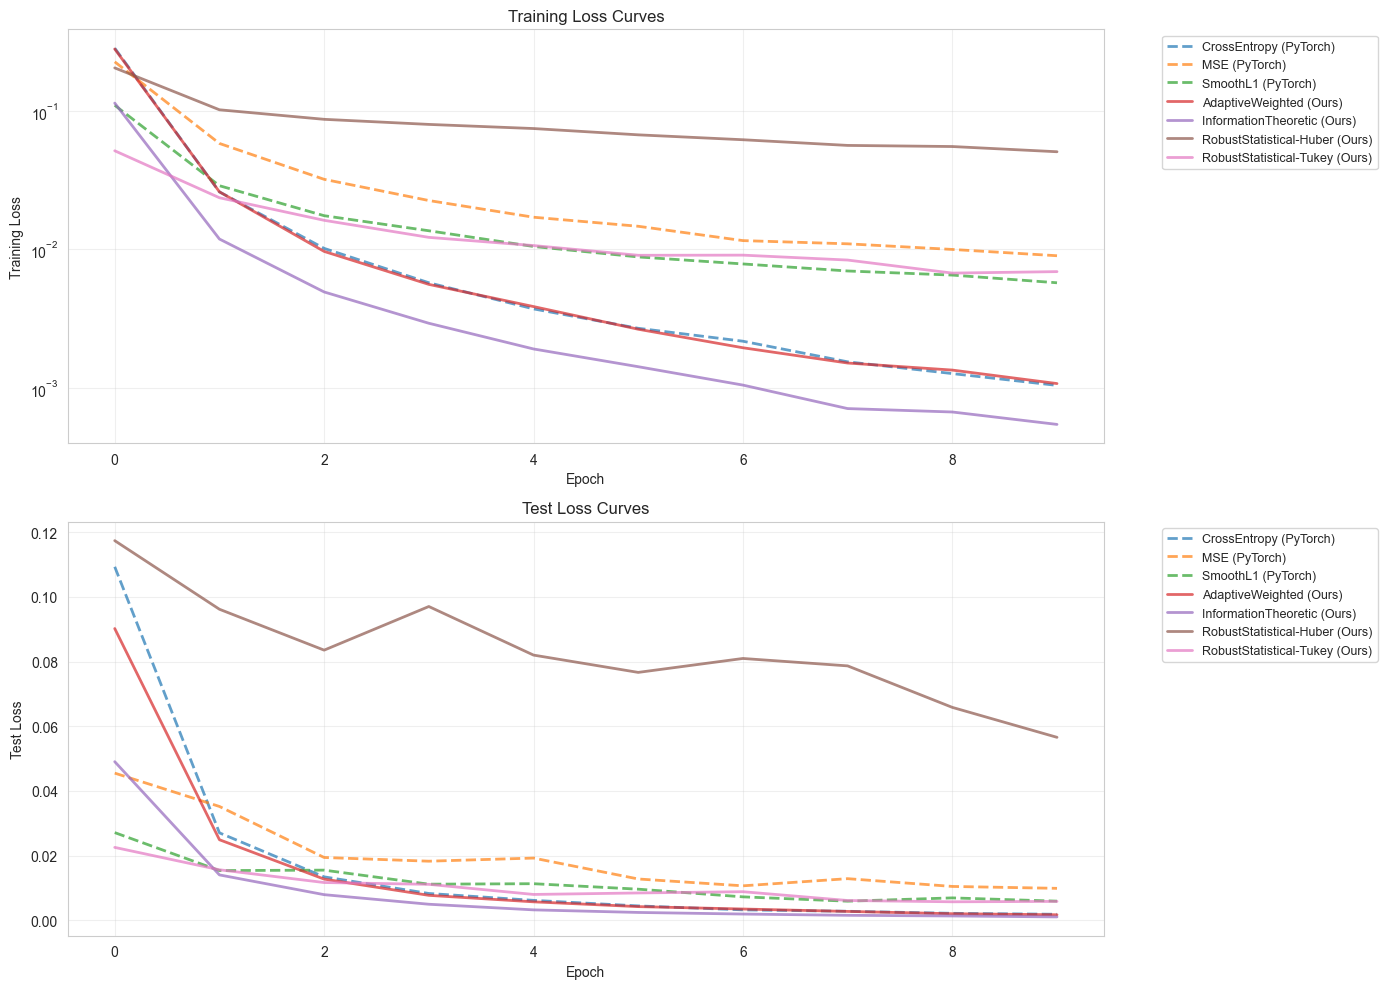

In [11]:
# Create detailed training curves
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Training Loss Curves
ax1 = axes[0]
for loss_name, result in all_results.items():
    linestyle = '-' if result['category'] == 'Novel' else '--'
    ax1.plot(result['metrics']['train_loss'], 
             label=loss_name, 
             linestyle=linestyle,
             linewidth=2,
             alpha=0.7)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Curves')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Test Loss Curves
ax2 = axes[1]
for loss_name, result in all_results.items():
    linestyle = '-' if result['category'] == 'Novel' else '--'
    ax2.plot(result['metrics']['test_loss'], 
             label=loss_name, 
             linestyle=linestyle,
             linewidth=2,
             alpha=0.7)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Loss')
ax2.set_title('Test Loss Curves')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 💾 Step 12: Save Results

In [12]:
import json
from datetime import datetime

# Prepare results for saving
results_to_save = {
    'timestamp': datetime.now().isoformat(),
    'dataset': DATASET_NAME,
    'num_train_samples': len(X_train),
    'num_test_samples': len(X_test),
    'num_features': X_train.shape[1],
    'num_classes': num_classes,
    'epochs': EPOCHS,
    'learning_rate': LR,
    'batch_size': BATCH_SIZE,
    'results': {}
}

for loss_name, result in all_results.items():
    results_to_save['results'][loss_name] = {
        'category': result['category'],
        'final_test_accuracy': result['final_test_acc'],
        'best_test_accuracy': max(result['metrics']['test_acc']),
        'training_time': result['training_time'],
        'train_loss_history': result['metrics']['train_loss'],
        'test_loss_history': result['metrics']['test_loss'],
        'train_acc_history': result['metrics']['train_acc'],
        'test_acc_history': result['metrics']['test_acc']
    }

# Save to JSON
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'huggingface_test_results_{DATASET_NAME}_{timestamp}.json'

with open(filename, 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(f"✅ Results saved to: {filename}")

# Save summary CSV
csv_filename = f'huggingface_test_summary_{DATASET_NAME}_{timestamp}.csv'
df_results.to_csv(csv_filename, index=False)
print(f"✅ Summary saved to: {csv_filename}")

✅ Results saved to: huggingface_test_results_imdb_20260217_015805.json
✅ Summary saved to: huggingface_test_summary_imdb_20260217_015805.csv


## 🎯 Step 13: Test with Noisy Data (Robustness Check)

In [13]:
# Add noise to test robustness
NOISE_LEVEL = 0.1  # 10% label noise

print(f"\n{'='*70}")
print(f"TESTING ROBUSTNESS WITH {NOISE_LEVEL*100}% LABEL NOISE")
print(f"{'='*70}")

# Add noise to training labels
y_train_noisy = y_train.clone()
n_noise = int(len(y_train_noisy) * NOISE_LEVEL)
noise_indices = np.random.choice(len(y_train_noisy), n_noise, replace=False)

for idx in noise_indices:
    original_label = y_train_noisy[idx].item()
    # Flip label
    y_train_noisy[idx] = (original_label + 1) % num_classes

print(f"Added noise to {n_noise} training labels ({NOISE_LEVEL*100}%)")

# Test only the best losses
robust_test_losses = {
    "CrossEntropy (PyTorch)": loss_functions["CrossEntropy (PyTorch)"],
    "RobustStatistical-Huber (Ours)": loss_functions["RobustStatistical-Huber (Ours)"],
    "RobustStatistical-Tukey (Ours)": loss_functions["RobustStatistical-Tukey (Ours)"]
}

robust_results = {}

for loss_name, loss_info in robust_test_losses.items():
    print(f"\nTesting {loss_name} with noise...")
    
    model = SimpleTextClassifier(input_dim, num_classes=num_classes)
    metrics = train_and_evaluate(
        model, loss_info['loss'],
        X_train, y_train_noisy, X_test, y_test,
        epochs=10, lr=0.001, batch_size=32
    )
    
    robust_results[loss_name] = {
        'category': loss_info['category'],
        'final_test_acc': metrics['final_test_acc'],
        'training_time': metrics['training_time']
    }
    
    print(f"   Test Accuracy: {metrics['final_test_acc']:.2f}%")

# Compare robustness
print(f"\n{'='*70}")
print("ROBUSTNESS COMPARISON")
print(f"{'='*70}")

baseline_acc = robust_results["CrossEntropy (PyTorch)"]['final_test_acc']
print(f"CrossEntropy with noise: {baseline_acc:.2f}%")

for loss_name in ["RobustStatistical-Huber (Ours)", "RobustStatistical-Tukey (Ours)"]:
    acc = robust_results[loss_name]['final_test_acc']
    improvement = acc - baseline_acc
    print(f"{loss_name}: {acc:.2f}% ({improvement:+.2f}%)")

if robust_results["RobustStatistical-Tukey (Ours)"]['final_test_acc'] > baseline_acc:
    improvement = robust_results["RobustStatistical-Tukey (Ours)"]['final_test_acc'] - baseline_acc
    print(f"\n✅ Robust losses handle noise better! (+{improvement:.2f}%)")


TESTING ROBUSTNESS WITH 10.0% LABEL NOISE
Added noise to 200 training labels (10.0%)

Testing CrossEntropy (PyTorch) with noise...
  Epoch 2/10: Train Loss=0.3031, Train Acc=90.02%, Test Acc=100.00%
  Epoch 4/10: Train Loss=0.1837, Train Acc=92.64%, Test Acc=96.75%
  Epoch 6/10: Train Loss=0.0896, Train Acc=96.82%, Test Acc=98.00%
  Epoch 8/10: Train Loss=0.0579, Train Acc=98.24%, Test Acc=98.00%
  Epoch 10/10: Train Loss=0.0376, Train Acc=98.89%, Test Acc=94.00%
   Test Accuracy: 94.00%

Testing RobustStatistical-Huber (Ours) with noise...
  Epoch 2/10: Train Loss=0.1610, Train Acc=89.57%, Test Acc=100.00%
  Epoch 4/10: Train Loss=0.1448, Train Acc=89.92%, Test Acc=100.00%
  Epoch 6/10: Train Loss=0.1367, Train Acc=90.02%, Test Acc=100.00%
  Epoch 8/10: Train Loss=0.1317, Train Acc=89.97%, Test Acc=100.00%
  Epoch 10/10: Train Loss=0.1260, Train Acc=90.02%, Test Acc=100.00%
   Test Accuracy: 100.00%

Testing RobustStatistical-Tukey (Ours) with noise...
  Epoch 2/10: Train Loss=0.0324

## 📝 Final Summary and Conclusions

In [14]:
# Generate final report
print("\n" + "="*70)
print("FINAL SUMMARY REPORT")
print("="*70)

print(f"\nDataset: {DATASET_NAME.upper()}")
print(f"Train Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {num_classes}")

print("\n" + "-"*70)
print("RANKED RESULTS (by Test Accuracy)")
print("-"*70)

for i, row in df_results.iterrows():
    marker = "✨" if row['Category'] == 'Novel' else "  "
    print(f"{marker} {i+1}. {row['Loss Function']:<40} {row['Final Test Accuracy (%)']:.2f}%")

print("\n" + "-"*70)
print("CATEGORY COMPARISON")
print("-"*70)
print(f"PyTorch Average: {avg_pytorch:.2f}%")
print(f"Novel Average:   {avg_novel:.2f}%")
print(f"Difference:      {avg_novel - avg_pytorch:+.2f}%")

# Key findings
print("\n" + "-"*70)
print("KEY FINDINGS")
print("-"*70)

best_novel = novel_results.iloc[0]
best_pytorch = pytorch_results.iloc[0]

print(f"\n1. Best Overall: {df_results.iloc[0]['Loss Function']} ({df_results.iloc[0]['Final Test Accuracy (%)']:.2f}%)")
print(f"   Category: {df_results.iloc[0]['Category']}")

print(f"\n2. Best PyTorch: {best_pytorch['Loss Function']} ({best_pytorch['Final Test Accuracy (%)']:.2f}%)")
print(f"   Best Novel:  {best_novel['Loss Function']} ({best_novel['Final Test Accuracy (%)']:.2f}%)")

if avg_novel > avg_pytorch:
    print(f"\n3. Novel framework provides {avg_novel - avg_pytorch:.2f}% improvement on average")
else:
    print(f"\n3. PyTorch provides {avg_pytorch - avg_novel:.2f}% improvement on average")

print("\n4. Speed Comparison:")
for _, row in df_results.iterrows():
    print(f"   {row['Loss Function']:<35} {row['Training Time (s)']:>6.1f}s")

print("\n" + "="*70)
print("✅ TESTING COMPLETED!")
print("="*70)


FINAL SUMMARY REPORT

Dataset: IMDB
Train Samples: 2000
Test Samples: 400
Features: 1000
Classes: 2

----------------------------------------------------------------------
RANKED RESULTS (by Test Accuracy)
----------------------------------------------------------------------
   1. CrossEntropy (PyTorch)                   100.00%
   2. MSE (PyTorch)                            100.00%
   3. SmoothL1 (PyTorch)                       100.00%
✨ 4. AdaptiveWeighted (Ours)                  100.00%
✨ 5. InformationTheoretic (Ours)              100.00%
✨ 6. RobustStatistical-Huber (Ours)           100.00%
✨ 7. RobustStatistical-Tukey (Ours)           100.00%

----------------------------------------------------------------------
CATEGORY COMPARISON
----------------------------------------------------------------------
PyTorch Average: 100.00%
Novel Average:   100.00%
Difference:      +0.00%

----------------------------------------------------------------------
KEY FINDINGS
-------------------

## 🎓 How to Interpret Results

### If Novel Losses Win:
- **Explanation**: Advanced features (curriculum, robustness, information theory) help
- **Recommendation**: Use novel losses for production with this dataset

### If PyTorch Wins:
- **Explanation**: Simple losses sufficient for this data, or need tuning
- **Recommendation**: Use PyTorch for speed, or tune novel losses more

### If Similar:
- **Explanation**: Both work well, trade-off is speed vs features
- **Recommendation**: Choose based on other requirements

---

**Next Steps**: Try different datasets, adjust hyperparameters, or test other loss functions!